In [42]:
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [43]:
path = '../Data/dff1.csv'

In [44]:
df= pd.read_csv(path, parse_dates=['ds'])
# df = df.rename(columns = {"Date":"ds","Close":"y"}) 
df = df[['ds', 'y','fbsp', 'diff','tby', 'ffr', 'fta', 'eps', 'div', 'une', 'wti', 'ppi',
       'rfs']]
# df

In [45]:
df['fbsp_tby'] = df['fbsp'] * df['tby']
df['fbsp_ffr'] = df['fbsp'] * df['ffr']
df['fbsp_div'] = df['fbsp'] * df['div']
df['eps_tby'] = df['eps'] * df['tby']
df['eps_ffr'] = df['eps'] * df['ffr']
df['eps_div'] = df['eps'] * df['div']

In [46]:
# cutoff between test and train data
cutoff = len(df) - 252
df_train = df[:cutoff].copy()
df_test = df[cutoff:].copy()
print(cutoff)

2300


In [47]:
df_train.columns

Index(['ds', 'y', 'fbsp', 'diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'une',
       'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby',
       'eps_ffr', 'eps_div'],
      dtype='object')

In [135]:
possible_features = ['tby', 'ffr', 'fta', 'eps', 'div', 'une', 'wti',
       'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby',
       'eps_ffr', 'eps_div']

from itertools import chain, combinations

def powerset(iterable):
    #"powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

#print(list(powerset(possible_features)))

In [136]:
len(possible_features)

15

In [137]:
from statsmodels.regression.linear_model import OLS

reg_new = OLS((df_train['diff']).copy(),df_train[possible_features].copy()).fit()
print(reg_new.params)

#from the output, we can see it's consistent with sklearn output

tby         305.980303
ffr         183.608289
fta           0.000065
eps          -1.775823
div        -142.530009
une         -80.692625
wti           3.378638
ppi          -7.923858
rfs           0.006087
fbsp_tby     -0.043153
fbsp_ffr     -0.146870
fbsp_div     -0.391168
eps_tby      -2.122760
eps_ffr       2.390346
eps_div       3.950103
dtype: float64


In [138]:
new_coef = reg_new.params
new_possible_feats = new_coef[abs(new_coef)>0].index

power_feats = list(powerset(new_possible_feats))
power_feats.remove(())

power_feats = [ list(feats) for feats in power_feats]
len(power_feats)


32767

In [139]:
AIC_scores = []
parameters = []

for feats in power_feats:
    tmp_reg = OLS((df_train['diff']).copy(),df_train[feats].copy()).fit()
    AIC_scores.append(tmp_reg.aic)
    parameters.append(tmp_reg.params)

    
Min_AIC_index = AIC_scores.index(min(AIC_scores))
Min_AIC_feats = power_feats[Min_AIC_index]  
Min_AIC_params  = parameters[Min_AIC_index]
print(Min_AIC_feats)
print(Min_AIC_params)  

['tby', 'ffr', 'fta', 'div', 'une', 'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby', 'eps_ffr', 'eps_div']
tby         313.791358
ffr         187.937377
fta           0.000057
div         -78.607290
une         -87.125044
wti           3.455364
ppi          -8.104355
rfs           0.005916
fbsp_tby     -0.046476
fbsp_ffr     -0.132070
fbsp_div     -0.388510
eps_tby      -2.157124
eps_ffr       2.033978
eps_div       3.252783
dtype: float64


In [140]:
len(Min_AIC_feats)

14

In [141]:
###After selecting the best features, we report the testing error, and make the plot 
AIC_df_test = df_test[Min_AIC_feats]
AIC_pred_test = AIC_df_test.dot(Min_AIC_params)+df_test.fbsp

AIC_df_train = df_train[Min_AIC_feats]
AIC_pred_train = AIC_df_train.dot(Min_AIC_params)+ df_train.fbsp



In [142]:
from sklearn.metrics import mean_squared_error as MSE

mse_train = MSE(df_train.y, AIC_pred_train) 
mse_test = MSE(df_test.y, AIC_pred_test)


#compare with fbprophet()

fb_mse_train = MSE(df_train.y, df_train.fbsp) 
fb_mse_test = MSE(df_test.y, df_test.fbsp)


print(mse_train,fb_mse_train)

print(mse_test,fb_mse_test)

2543.6188296247346 22303.563608543613
11928.655041711927 15247.912341091072


In [143]:
df_train.ds

0      2009-12-15
1      2009-12-16
2      2009-12-17
3      2009-12-18
4      2009-12-21
          ...    
2295   2019-02-20
2296   2019-02-21
2297   2019-02-22
2298   2019-02-25
2299   2019-02-26
Name: ds, Length: 2300, dtype: datetime64[ns]

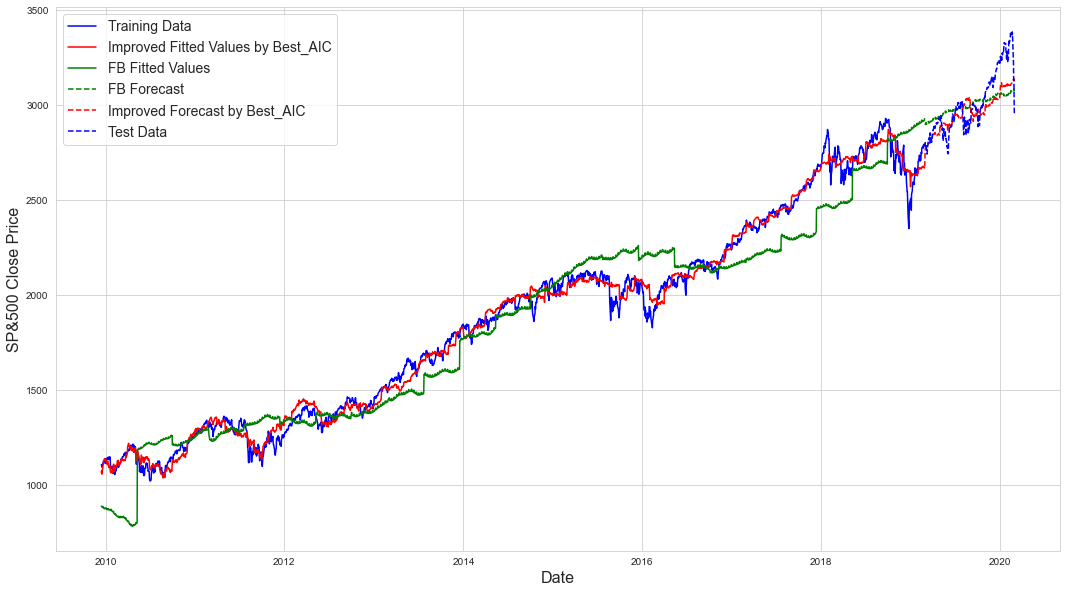

In [144]:
plt.figure(figsize=(18,10))

# plot the training data
plt.plot(df_train.ds,df_train.y,'b',
            label = "Training Data")

plt.plot(df_train.ds, AIC_pred_train,'r-',
            label = "Improved Fitted Values by Best_AIC")

# # plot the fit
plt.plot(df_train.ds, df_train.fbsp,'g-',
            label = "FB Fitted Values")

# # plot the forecast
plt.plot(df_test.ds, df_test.fbsp,'g--',
            label = "FB Forecast")
plt.plot(df_test.ds, AIC_pred_test,'r--',
            label = "Improved Forecast by Best_AIC")
plt.plot(df_test.ds,df_test.y,'b--',
            label = "Test Data")

plt.legend(fontsize=14)

plt.xlabel("Date", fontsize=16)
plt.ylabel("SP&500 Close Price", fontsize=16)

plt.show()

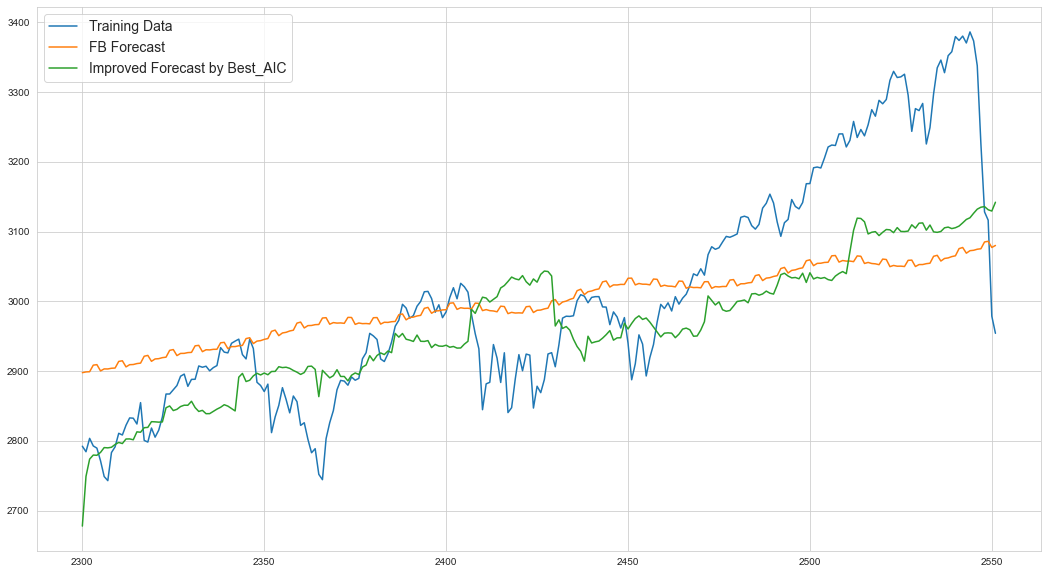

In [145]:
plt.figure(figsize=(18,10))
plt.plot(df_test.y,label="Training Data")
plt.plot(df_test.fbsp,label="FB Forecast")
plt.plot(AIC_pred_test,label="Improved Forecast by Best_AIC")
plt.legend(fontsize = 14)
plt.show()

In [23]:
column = ['tby', 'ffr', 'fta', 'eps', 'div', 'une',
                                                  'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby', 'eps_ffr', 'eps_div']

In [48]:
from sklearn import preprocessing
df1_train = df_train[['diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'une', 'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby', 'eps_ffr', 'eps_div']]

X = preprocessing.scale(df1_train)
from statsmodels.regression.linear_model import OLS

reg_new = OLS((X[:,0]).copy(),X[:,1:].copy()).fit()
print(reg_new.params)

[ 1.50405129  1.03228322  0.27409454  1.17073571  0.31243092 -0.75747342
  0.46988206 -0.39944639  2.10369448 -0.69112943 -2.1804296  -2.38576385
 -1.14196633  1.41832903 -0.34501927]


In [86]:
# Before Covid
# pd.Series(reg_new.params, index=['tby', 'ffr', 'fta', 'eps', 'div', 'une',
#                                                   'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby', 'eps_ffr', 'eps_div'] )

In [71]:
# before covid
coef1 = [ 1.50405129,  1.03228322,  0.27409454,  1.17073571,  0.31243092,
       -0.75747342,  0.46988206, -0.39944639,  2.10369448, -0.69112943,
       -2.1804296 , -2.38576385, -1.14196633,  1.41832903, -0.34501927]
# include covid
coef2 = [ 0.65150054,  1.70457239, -0.1573802 , -0.18007979, -0.15221931,
       -0.62326075,  0.45065894, -0.38972706,  2.87210843, -1.17604495,
       -4.92858316, -2.15459111,  0.11418468,  2.74829778,  0.55520382]

In [85]:
# Include Covid
# pd.Series( np.append( ['coefficients (before covid)'], np.round(coef1,3)),  index= np.append(['features'], column) ) 
                                        

In [61]:
index = ['10 Year U.S Treasury Bond Yield Rates (tby)', 'Federal Funds Rates (ffr)',
        'Federal Total Assets (fta)', 'Earning-Per-Share of S&P 500 (eps)', 'Dividend Yield of S&P 500 (div)',
        'Unemployment Rates (une) ', 'West Texas Intermediate oil index (wit)', 'Producer Price Index (ppi)',
         'Retail and Food Services Sales (rfs)', 
         'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby', 'eps_ffr', 'eps_div'
        ]

In [62]:
len(index)

15

In [81]:
pd.Series(coef2, index =index1)

10 Year U.S Treasury Bond Yield Rates (tby)    0.651501
Federal Funds Rates (ffr)                      1.704572
Federal Total Assets (fta)                    -0.157380
Earning-Per-Share of S&P 500 (eps)            -0.180080
Dividend Yield of S&P 500 (div)               -0.152219
Unemployment Rates (une)                      -0.623261
West Texas Intermediate oil index (wit)        0.450659
Producer Price Index (ppi)                    -0.389727
Retail and Food Services Sales (rfs)           2.872108
fbsp_tby                                      -1.176045
fbsp_ffr                                      -4.928583
fbsp_div                                      -2.154591
eps_tby                                        0.114185
eps_ffr                                        2.748298
eps_div                                        0.555204
dtype: float64

In [84]:
df3 = pd.DataFrame(coef1, index = index1, columns = ['coefficients (before covid)'])
df3['coefficients (include covid)'] =pd.Series(coef2, index =index1)
df3

coefficients (before covid)  \
10 Year U.S Treasury Bond Yield Rates (tby)                     1.504051   
Federal Funds Rates (ffr)                                       1.032283   
Federal Total Assets (fta)                                      0.274095   
Earning-Per-Share of S&P 500 (eps)                              1.170736   
Dividend Yield of S&P 500 (div)                                 0.312431   
Unemployment Rates (une)                                       -0.757473   
West Texas Intermediate oil index (wit)                         0.469882   
Producer Price Index (ppi)                                     -0.399446   
Retail and Food Services Sales (rfs)                            2.103694   
fbsp_tby                                                       -0.691129   
fbsp_ffr                                                       -2.180430   
fbsp_div                                                       -2.385764   
eps_tby                                                        -1.141966   
eps_ffr                                                         1.418329   
eps_div                                                        -0.345019   

                                             coefficients (include covid)  
10 Year U.S Treasury Bond Yield Rates (tby)                      0.651501  
Federal Funds Rates (ffr)                                        1.704572  
Federal Total Assets (fta)                                      -0.157380  
Earning-Per-Share of S&P 500 (eps)                              -0.180080  
Dividend Yield of S&P 500 (div)                                 -0.152219  
Unemployment Rates (une)                                        -0.623261  
West Texas Intermediate oil index (wit)                          0.450659  
Producer Price Index (ppi)                                      -0.389727  
Retail and Food Services Sales (rfs)                             2.872108  
fbsp_tby                                                        -1.176045  
fbsp_ffr                                                        -4.928583  
fbsp_div                                                        -2.154591  
eps_tby                                                          0.114185  
eps_ffr                                                          2.748298  
eps_div                                                          0.555204